In [1]:
from py2neo import Graph
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [3]:
# Change the line of code below to use the IP Address, Bolt Port, and Password of your Sandbox.
# graph = Graph("bolt://<IP Address>:<Bolt Port>", auth=("neo4j", "<Password>")) 
 
graph = Graph("bolt://localhost:11014", auth=("hera", "hera"))

In [4]:
from collections import Counter

In [5]:
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

In [6]:
train_existing_links_log = graph.run("""
MATCH (author:Author)-[:COAUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

train_missing_links_log = graph.run("""
MATCH (author:Author)
WHERE (author)-[:COAUTHOR_EARLY]-()
MATCH (author)-[:COAUTHOR_EARLY*2..3]-(other)
WHERE not((author)-[:COAUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
train_missing_links_log = train_missing_links_log.drop_duplicates()

In [7]:
training_df_log = train_missing_links_log.append(train_existing_links_log, ignore_index=True)
training_df_log['label'] = training_df_log['label'].astype('category')
training_df_log = down_sample(training_df_log)

In [8]:
training_df_log.head()

,node1,node2,label
126245,15570,43542,0
584901,52852,100706,0
975918,10959,10961,1
1008772,25562,25563,1
1037808,72820,72821,1


In [9]:
test_existing_links_log = graph.run("""
MATCH (author:Author)-[:COAUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

test_missing_links_log = graph.run("""
MATCH (author:Author)
WHERE (author)-[:COAUTHOR_LATE]-()
MATCH (author)-[:COAUTHOR_LATE*2..3]-(other)
WHERE not((author)-[:COAUTHOR_LATE]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
test_missing_links_log = test_missing_links_log.drop_duplicates()

In [11]:
test_df_log = test_missing_links_log.append(test_existing_links_log, ignore_index=True)
test_df_log['label'] = test_df_log['label'].astype('category')
test_df_log = down_sample(test_df_log)

In [12]:
test_df_log.head()

,node1,node2,label
1163531,118412,53349,0
799620,81239,71969,0
1039251,100859,70321,0
1306521,70055,71439,1
1276450,16783,29439,1


In [13]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

In [14]:
classifier_log = LogisticRegression(solver='saga',max_iter=50)

In [17]:
def apply_graphy_features_log(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           gds.alpha.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           gds.alpha.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           gds.alpha.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [18]:
training_df_log = apply_graphy_features_log(training_df_log, "COAUTHOR_EARLY")

In [19]:
training_df_log.head()

,node1,node2,label,cn,pa,tn
0,15570,43542,0,0.0,68.0,21.0
1,52852,100706,0,1.0,20.0,8.0
2,10959,10961,1,1.0,4.0,3.0
3,25562,25563,1,3.0,16.0,5.0
4,72820,72821,1,1.0,4.0,3.0


In [20]:
test_df_log = apply_graphy_features_log(test_df_log, "COAUTHOR_LATE")

In [21]:
test_df_log.head()

,node1,node2,label,cn,pa,tn
0,118412,53349,0,1.0,10.0,6.0
1,81239,71969,0,0.0,76.0,23.0
2,100859,70321,0,1.0,27.0,11.0
3,70055,71439,1,3.0,414.0,52.0
4,16783,29439,1,5.0,160.0,23.0


In [22]:
columns = ["cn", "pa", "tn"]

X = training_df_log[columns]
y = training_df_log["label"]
classifier_log.fit(X, y)

predictions = classifier_log.predict(test_df_log[columns])
y_test = test_df_log["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))
cnf_matrix = confusion_matrix(y_test, predictions)
display("Confusion Matrix", confusion_matrix(y_test, predictions))
print("Classification Report\n", classification_report(y_test, predictions))



C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'Accuracy'

0.856504964385927

'Precision'

0.907585058144915

'Recall'

0.7938430822361321

'Confusion Matrix'

array([[68136,  5992],
       [15282, 58846]], dtype=int64)

Classification Report
               precision    recall  f1-score   support

           0       0.82      0.92      0.86     74128
           1       0.91      0.79      0.85     74128

    accuracy                           0.86    148256
   macro avg       0.86      0.86      0.86    148256
weighted avg       0.86      0.86      0.86    148256



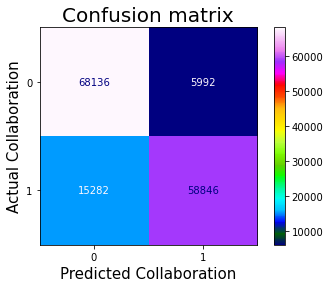

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot(cmap='gist_ncar', values_format = '.0f')
disp.ax_.grid(False)
plt.title('Confusion matrix', fontsize = 20)
plt.ylabel('Actual Collaboration', fontsize = 15)
plt.xlabel('Predicted Collaboration', fontsize = 15)
plt.show()

In [24]:
from sklearn import metrics
probs = classifier_log.predict_proba(test_df_log[columns])
probs = [p[1] for p in probs]
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
roc_auc = metrics.roc_auc_score(y_test, probs)

Text(0, 0.5, 'True Positive Rate')

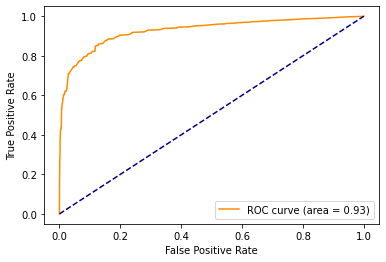

In [25]:
plt.plot(fpr, tpr, color = 'darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Logistic Regression for 3/4 Hops

In [26]:
train_existing_links_log1 = graph.run("""
MATCH (author:Author)-[:COAUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

train_missing_links_log1 = graph.run("""
MATCH (author:Author)
WHERE (author)-[:COAUTHOR_EARLY]-()
MATCH (author)-[:COAUTHOR_EARLY*3..4]-(other)
WHERE not((author)-[:COAUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
train_missing_links_log1 = train_missing_links_log1.drop_duplicates()

In [27]:
training_df_log1 = train_missing_links_log1.append(train_existing_links_log1, ignore_index=True)
training_df_log1['label'] = training_df_log1['label'].astype('category')
training_df_log1 = down_sample(training_df_log1)

In [28]:
training_df_log1.head()

,node1,node2,label
2373767,56674,67757,1
2380035,75209,80121,1
457058,18350,13150,0
65465,10822,78935,0
2309780,131838,56934,0


In [29]:
test_existing_links_log1 = graph.run("""
MATCH (author:Author)-[:COAUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

test_missing_links_log1 = graph.run("""
MATCH (author:Author)
WHERE (author)-[:COAUTHOR_LATE]-()
MATCH (author)-[:COAUTHOR_LATE*3..4]-(other)
WHERE not((author)-[:COAUTHOR_LATE]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
test_missing_links_log1 = test_missing_links_log1.drop_duplicates()

In [30]:
test_df_log1 = test_missing_links_log1.append(test_existing_links_log1, ignore_index=True)
test_df_log1['label'] = test_df_log1['label'].astype('category')
test_df_log1 = down_sample(test_df_log1)

In [31]:
test_df_log1.head()

,node1,node2,label
788297,29927,11521,0
556993,23545,19144,0
3140859,99713,103237,0
3909464,43874,69381,1
3912417,47734,124209,1


In [32]:
training_df_log1 = apply_graphy_features_log(training_df_log1, "COAUTHOR_EARLY")

In [33]:
training_df_log1.head()

,node1,node2,label,cn,pa,tn
0,56674,67757,1,2.0,12.0,5.0
1,75209,80121,1,1.0,12.0,7.0
2,18350,13150,0,0.0,420.0,43.0
3,10822,78935,0,0.0,1.0,2.0
4,131838,56934,0,0.0,28.0,11.0


In [34]:
test_df_log1 = apply_graphy_features_log(test_df_log1, "COAUTHOR_LATE")

In [35]:
test_df_log1.head()

,node1,node2,label,cn,pa,tn
0,29927,11521,0,0.0,87.0,32.0
1,23545,19144,0,0.0,68.0,36.0
2,99713,103237,0,0.0,8.0,6.0
3,43874,69381,1,2.0,15.0,6.0
4,47734,124209,1,3.0,72.0,19.0


In [36]:
columns = ["cn", "pa", "tn"]

X = training_df_log1[columns]
y = training_df_log1["label"]
classifier_log.fit(X, y)

predictions = classifier_log.predict(test_df_log1[columns])
y_test1 = test_df_log1["label"]

display("Accuracy", accuracy_score(y_test1, predictions))
display("Precision", precision_score(y_test1, predictions))
display("Recall", recall_score(y_test1, predictions))
cnf_matrix = confusion_matrix(y_test1, predictions)
display("Confusion Matrix", confusion_matrix(y_test1, predictions))
print("Classification Report\n", classification_report(y_test1, predictions))

C:\Users\Hera\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'Accuracy'

0.8913905676667386

'Precision'

0.963688668691066

'Recall'

0.8134308223613209

'Confusion Matrix'

array([[71856,  2272],
       [13830, 60298]], dtype=int64)

Classification Report
               precision    recall  f1-score   support

           0       0.84      0.97      0.90     74128
           1       0.96      0.81      0.88     74128

    accuracy                           0.89    148256
   macro avg       0.90      0.89      0.89    148256
weighted avg       0.90      0.89      0.89    148256



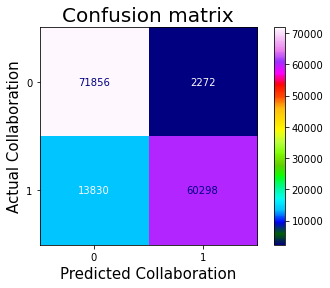

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot(cmap='gist_ncar', values_format = '.0f')
disp.ax_.grid(False)
plt.title('Confusion matrix', fontsize = 20)
plt.ylabel('Actual Collaboration', fontsize = 15)
plt.xlabel('Predicted Collaboration', fontsize = 15)
plt.show()

In [38]:
from sklearn import metrics
probs = classifier_log.predict_proba(test_df_log1[columns])
probs = [p[1] for p in probs]
fpr, tpr, thresholds = metrics.roc_curve(y_test1, probs)
roc_auc = metrics.roc_auc_score(y_test1, probs)

Text(0, 0.5, 'True Positive Rate')

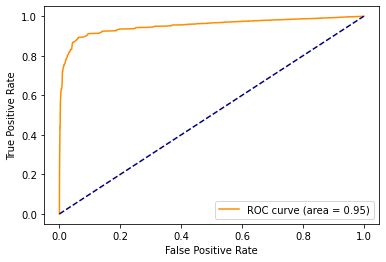

In [39]:
plt.plot(fpr, tpr, color = 'darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')